<a href="https://colab.research.google.com/github/Stern1710/SoSe2024/blob/main/ArangoDBTutorial_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![arangodb](https://github.com/arangodb/interactive_tutorials/blob/master/notebooks/img/ArangoDB_logo.png?raw=1)

ArangoDB Query Language (AQL) Tutorial

# Overview
* A non-relational open source database management system.
* Multi-model: supporting documents, key/value, and graphs.
* Native: supports all data models with one database core and one query language (AQL).
* Collection, document, and attribute in ArangoDB are equivalent to table, row, and column respectively in relational databases.

ArangoDB AQL | Neo4j Cypher
:- | :-
Vertex | Node
Edge | Relationship
Collection | Group of nodes
Document collection | Nodel label
Edge collection | Relationship type
Attribute | Property


Vertices and edges are represented as documents.

# Getting Started

Execute the code snippets below to create a temporary database on ArangoDB's managed Service Oasis.

In this tutorial, you can interact with ArangoDB using its web interface or here using Python.

In [ ]:
%%capture
!git clone https://github.com/AyaKhaled1/ArangoDB-Tutorial.git
!rsync -av ArangoDB-Tutorial/ ./ --exclude=.git
!pip3 install pyarango
!pip3 install "python-arango>=5.0"

In [ ]:
import json
import requests
import sys
import oasis
import time

from pyArango.connection import *
from arango import ArangoClient

Create the temporary database:

In [ ]:
# Retrieve tmp credentials from ArangoDB Tutorial Service
login = oasis.getTempCredentials(credentialProvider='https://tutorials.arangodb.cloud:8529/_db/_system/tutorialDB/tutorialDB')

conn = oasis.connect(login)
db = conn[login["dbName"]]

Execute the cell code and use the URL below and the generated credentials to access the ArangoDB Web UI.

In [ ]:
print("https://"+login["hostname"]+":"+str(login["port"]))
print("Username: " + login["username"])
print("Password: " + login["password"])
print("Database: " + login["dbName"])

#  Create, Read, Update, and Delete (CRUD) Operations

## Create Collections

There are four ways to create a collection:
* Web interface
* Driver (like we are doing here in python)
* Arangoshell (installing ArangoDB is a prerequisite)

*Note*: AQL does not support data definition operations including creating and dropping databases, collections, and indexes.

In [ ]:
db.createCollection(name="users")

## Create Documents
**Syntax**: `INSERT document INTO collectionName`


* The document is an object (like in JavaScript or JSON).
* It is comprised of attribute key and value pairs.
* Keys are strings (surrounding quotes are optional).
* Attribute values can be null, boolean (true/false), number (integer and floating point), string, array, or object.

In [ ]:
insert_query = """
INSERT {
    "firstname": "Anna",
    "lastname": "Wilson",
    "_key": "k11111111",
    "birthdate": "1998-12-01",
    "origin": "IT"
} INTO users
"""

db.AQLQuery(insert_query)

*Note*: You can also execute all the queries from the ArangoDB Web UI which you can access using the link and login information above.

## Read Documents

**Syntax**: `FOR variableName IN collectionName`

Now let's query the `users` collections.
For each document in the collection, u is assigned a document, which is then returned as per the loop body.

In [ ]:
all_users = """
FOR u IN users
    RETURN u
"""

query_result = db.AQLQuery(all_users, rawResults=True)
for doc in  query_result:
    print(doc)
    print()

`_key, _id, _rev` are read-only system database attribute:
* `_key` is a unique identifer within the collection. It can be provided by the user upon document creation. Otherwise a unique value is assigned automatically. It cannot be changed later.
* The `_id` is a concatenation of the collection name, a forward slash `/` and the document key. It uniquely identifies a document within a database.
* `_rev` is a revision ID managed by the system.

### LET

Next, let us add some more users. The `LET` keyword defines a variable with name data and an array of objects as value.

**Syntax**: `LET expressionVariable = [ {...}, {...}, ... ]`

`FOR variableName IN expressionVariable` is used to iterate over the array where element is assigned to the defined variable. This variable is then used in the `INSERT` statement.

In [ ]:
insert_query = """
LET data = [
{ "firstname":"Ardelis", "lastname":"Lerven", "_key": "ak123456", "birthdate": "1982-10-23", "title":"MSc.", "origin":"FR" },
{ "firstname":"Jane","lastname":"Bambury", "_key": "k22222222", "birthdate": "1995-09-13", "origin":"AT" },
{ "firstname":"Sergeant","lastname":"Peter", "_key": "k33333333", "birthdate": "1996-09-01", "origin":"DE" },
{ "firstname":"Wilone", "lastname":"Pearmain", "_key": "k44444444", "birthdate": "1998-05-31", "origin":"IT" },
{ "firstname":"Joe", "lastname":"Gormally", "_key": "k55555555", "birthdate": "1997-02-11", "origin":"FR" },
{ "firstname":"Raymund","lastname":"Capron", "_key": "ak123987", "birthdate": "1990-09-13", "title":"DI.", "origin":"AT" },
{ "firstname":"Rosana", "lastname":"Parley", "_key": "ak123457", "birthdate": "1978-07-14", "title":"Univ.-Prof. Dr.", "origin":"DE" },
{ "firstname":"Rebekah","lastname":"Adie", "_key": "k66666666", "birthdate": "1999-04-26", "origin":"AT" },
{ "firstname":"Erek", "lastname":"Ferriman", "_key": "ak123467", "birthdate": "1975-11-03", "title":"Univ.-Prof. Dr.", "origin":"AT" },
{ "firstname":"Danette" ,"lastname":"Wilson", "_key": "ak133457", "birthdate": "1988-03-10", "title":"Mag.", "origin":"GR" }
]

FOR d IN data
    INSERT d INTO users
"""

db.AQLQuery(insert_query)

### Limit

The result array is sliced such that the number of elements in the result is reduced to the specified number (at most).

**Syntax**: `LIMIT [offset] count`

*Note*: the offset between the squared bracketets is optional.

### Sort

**Syntax**: `SORT variableName.attributeName [DESC]`

Now let us retrieve the top 5 user names from the `users` collection sorted according to their birthdate in descending order.

In [ ]:
all_users_firstnames = """
FOR u IN users
    SORT u.birthdate DESC
    LIMIT 5
    RETURN u.firstname
"""

query_result = db.AQLQuery(all_users_firstnames, rawResults=True)
for doc in  query_result:
    print(doc)
    print()

### Filter

The `FILTER` statement can be used to restrict the results to elements matching the specified condition(s) that evaluate to either `true` or `false`. If the condition is true, the current element is not skipped and can be further processed. Otherwise, this element will not be part of the result

**Syntax**: `FILTER expression`

In this example below, we will list the users with first names starting with 'R'.

In [ ]:
filter_example = """
FOR u in users
FILTER LIKE(u.firstname,"R%")
RETURN u.firstname
"""

query_result = db.AQLQuery(filter_example, rawResults=True)
for doc in  query_result:
    print(doc)
    print()

*Note*: For case insensitive `like` comparison, add `true` as a third parameter.

**Exercise**:
* List all the users excluding those having `null` titles.
* Get the users having the last name of "Wilson".
* Get the professors (hint: use `like` operator for their title).

### Collect

The `COLLECT` keyword can be used to group an array by one or multiple group criteria.

**Syntax**: `COLLECT variableName = expression [INTO groupsVariable]`

*Note*: Check the [`COLLECT` documentation](https://www.arangodb.com/docs/3.7/aql/operations-collect.html) for other syntax variants.

**Example 1**: Classify users to employee and student according to their `_key`.

In [ ]:
collect_example1 = """
FOR u IN users
  COLLECT userType = LIKE(u._key,"ak%")?"Employee":"Student" INTO groups
  RETURN {
    "type" : userType,
    "users" : groups[*].u.firstname
  }
"""

query_result = db.AQLQuery(collect_example1, rawResults=True)
for doc in  query_result:
    print(doc)
    print()

**Example 2**: Get students who are born in the same year

In [ ]:
collect_example2 = """
FOR u IN users
  FILTER LIKE(u._key,"k%")
  COLLECT birthyear = DATE_YEAR(u.birthdate) INTO groups
  FILTER LENGTH(groups) > 1
  RETURN {
    "year" : birthyear,
    "users" : groups[*].u._id
  }
"""

query_result = db.AQLQuery(collect_example2, rawResults=True)
for doc in  query_result:
    print(doc)
    print()

### Join

There is an attribute called `origin` representing the country code for each entry in the collection `users`. Let's create a new collection `countries` and add the country code and its respective name.

In [ ]:
db.createCollection(name="countries")

In [ ]:
insert_query = """
LET countriesData = [
{ "_key":"FR", "name":"France" },
{ "_key":"DE", "name":"Germany" },
{ "_key":"AT", "name":"Austria" },
{ "_key":"IT", "name":"Italy" },
{ "_key":"GR", "name":"Greece" },
{ "_key":"BE", "name":"Belgium" },
{ "_key":"FI", "name":"Finland" }
]

FOR c IN countriesData
    INSERT c INTO countries
"""

db.AQLQuery(insert_query)

In the following example, we will join the country code in the `users` collection with the corresponding name from the `countries` collection.


* The `DOCUMENT()` function is used to look up a single or multiple documents via the identifier. In our example, we pass the collection name from which we want to fetch documents as the first argument ("countries") and an array of document representing the values of the `_key` attribute as the second argument.
* The `MERGE()` function merges objects together. Because we used an object { origin: ... } which has the same attribute name as in the `users` collection, the latter got overwritten by the merge operation.

In [ ]:
document_example = """
FOR u IN users
RETURN MERGE(u, { origin: DOCUMENT("countries", u.origin).name } )
"""

query_result = db.AQLQuery(document_example, rawResults=True)
for doc in  query_result:
    print(doc)
    print()

Another, more flexible syntax for joins is to use nested `FOR` loops over multiple collections, with a `FILTER` condition to match up attributes.

In [ ]:
join_example = """
FOR u IN users
  RETURN MERGE(u, {
    origin: (
        FOR c IN countries
          FILTER c._key == u.origin
          RETURN c.name
    )
  })
"""

query_result = db.AQLQuery(join_example, rawResults=True)
for doc in  query_result:
    print(doc)
    print()

## Update Documents

According to our Ardelis Lerven document, she is a master's holder. When she get her PhD, we need to change the title attribute. Let us modify the existing document. For this, we first identify the above `_key` attribute.

In [ ]:
find_ardelis_query = """
FOR u IN users
    FILTER u.firstname == "Ardelis"
    RETURN u._key
"""

ardelis_document_key = None
query_result = db.AQLQuery(find_ardelis_query, rawResults=True)
for doc in  query_result:
    print("_key: " + str(doc))
    ardelis_document_key = doc
    print()

**Syntax**: `UPDATE key WITH { attribute: newValue } IN collectionName`

In [ ]:
update_ardelis = """
UPDATE @key
WITH { title: "Dr."}
IN users
"""
bindVars = {'key': ardelis_document_key}
db.AQLQuery(update_ardelis, rawResults=False, batchSize=1, bindVars=bindVars)

We could have also replaced the entire document content, using `REPLACE` instead of `UPDATE`:

In [ ]:
update_ardelis = """
REPLACE @key WITH {
    firstname: "Ardelis",
    lastname:"Lerven",
    birthdate: "1982-10-23",
    title:"Dr.",
    origin:"FR"
} IN users
"""
bindVars = {'key': ardelis_document_key}
db.AQLQuery(update_ardelis, rawResults=False, batchSize=1, bindVars=bindVars)

# Check the updated Ardelis document
find_ardelis_query = """
FOR u IN users
    FILTER u.firstname == "Ardelis"
    RETURN u
"""
query_result = db.AQLQuery(find_ardelis_query, rawResults=True)
for doc in  query_result:
    print(doc)
    print()

We could again use the `FOR` loop construct from before to update all users:

In [ ]:
email_query = """
FOR u IN users
    UPDATE u WITH { email: LIKE(u._key,"ak%")?
    CONCAT(LOWER(u.firstname),".",LOWER(u.lastname),"@jku.at")
    :CONCAT(u._key,"@student.jku.at") } IN users
"""
db.AQLQuery(email_query, rawResults=False)

# Retrieve all users and their emails
all_users_names_emails = """
FOR u IN users
    RETURN {"Name" : CONCAT(u.firstname, " ", u.lastname), "Email" : u.email}
"""

query_result = db.AQLQuery(all_users_names_emails, rawResults=True)
for doc in  query_result:
    print(doc)
    print()

*Note*: `RETURN` is customized to return a json document consisting of name and email.

## Delete Documents

**Syntax**: `REMOVE key IN collectionName`

In [ ]:
remove_ardelis = """
REMOVE @key IN users
"""
bindVars = {'key': ardelis_document_key}
try:
    db.AQLQuery(remove_ardelis, rawResults=False, batchSize=1, bindVars=bindVars)
except:
    print("Ardelis already removed.")

# The updated Ardelis document should be empty
find_ardelis_query = """
FOR u IN users
    FILTER u.firstname == "Ardelis"
    RETURN u
"""
query_result = db.AQLQuery(find_ardelis_query, rawResults=True)
if len(query_result) == 0 :
    print("Ardelis not found.")

*Note*: `FOR` loop can be used if we want to perform this operation for the entire collection.



In [ ]:
remove_all = """
FOR u IN users
    REMOVE u IN users
"""
db.AQLQuery(remove_all, rawResults=False)

all_users_available = """
FOR u IN users
    RETURN u
"""

query_result = db.AQLQuery(all_users_available, rawResults=True)
if len(query_result) == 0 :
    print("No users left.")

# Graphs

Execute the code below to import the flights example dataset into the database, having more than 3,000 airports and roughly 300,000 flights from January 1st to 15th, 2008.

In [ ]:
!chmod 755 ./tools/*
!./tools/arangorestore -c none --server.endpoint http+ssl://{login["hostname"]}:{login["port"]} --server.username {login["username"]} --server.database {login["dbName"]} --server.password {login["password"]} --input-directory "./airport-dataset"

You can then find the `airport` document collection, having name, city, state, country, etc. The `flights` edge collection connects the airports and consists of _from, _to, flight number, departure time, arrival time, distance, etc.

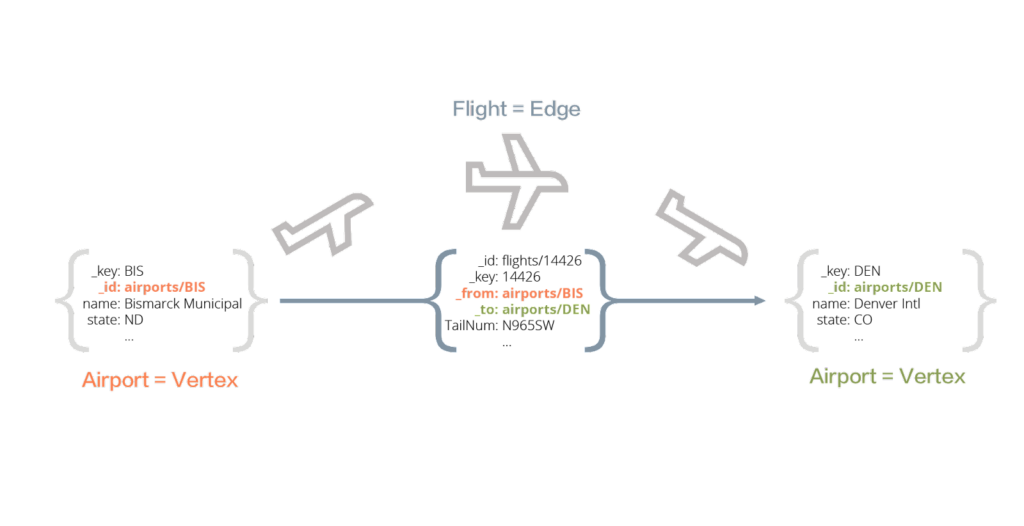

To create a graph from the web interface, go to `GRAPHS` from the main menu and select the `Add Graph` option. Then, define the vertices and edges collections as below:

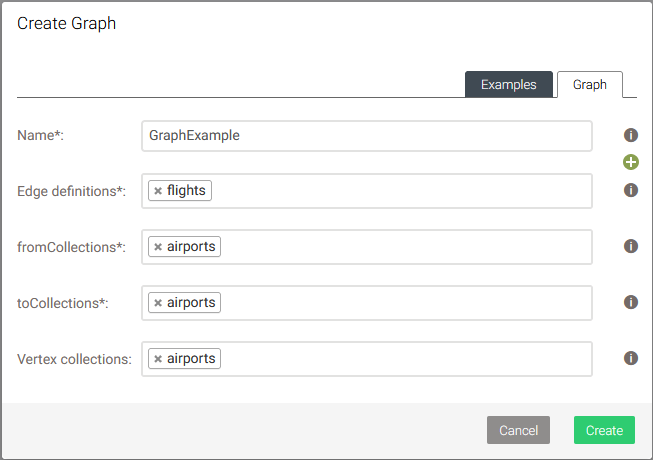

## Shortest Path

**Syntax**:
```
FOR path IN OUTBOUND|INBOUND|ANY
[SHORTEST_PATH | K_SHORTEST_PATHS] "startVertexId" TO "destinationVertexId"
edgeCollection[, more…] | GRAPH "graphName"
[LIMIT]
RETURN
```

* Query the shortest path between two documents given their `_id`.
* List the paths between them, sorted by length, or weight.
* Outbound, inbound, and any are the possible edge directions (see figure below).



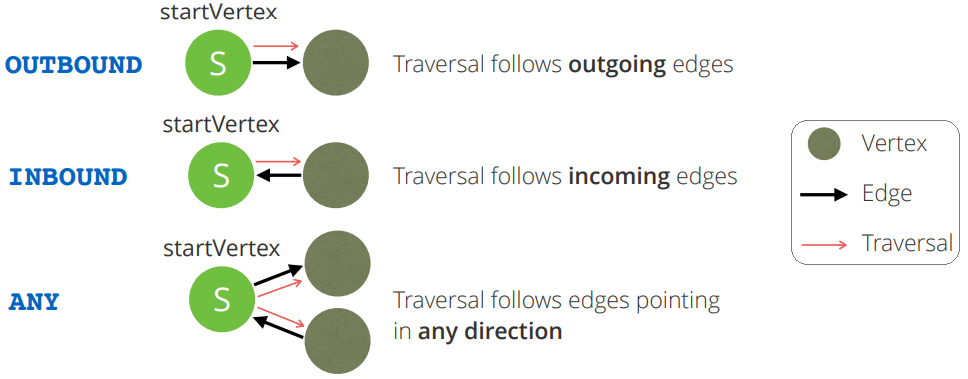

Let us now try to find a connection between two airports with the fewest stops.

In [ ]:
shortest_path_query = """
WITH airports
FOR v IN OUTBOUND
SHORTEST_PATH 'airports/ITO' TO 'airports/SFO' flights
RETURN v.name
"""

query_result = db.AQLQuery(shortest_path_query, rawResults=True)
for res in  query_result:
    print(res)

The result of the previous shortest path query shows that you have to change in Honolulu (HNL), for example, to get to San Francisco (SFO). There is apparently no direct flight.

To return only the length of the shortest path, execute the query below.

In [ ]:
len_shortest_path_query = """
WITH airports
LET path = (
  FOR v IN OUTBOUND
  SHORTEST_PATH 'airports/ITO' TO 'airports/SFO' flights
  RETURN v
)
RETURN LENGTH(path) - 1
"""

pathLength = db.AQLQuery(len_shortest_path_query, rawResults=True)
for res in  pathLength:
    print(res)

* `LIMIT` should always be used with `K_SHORTEST_PATHS`. Otherwise, this can lead to an expensive, exhaustive search through the graph.
* However, filters cannot be applied in the shortest path query. Therefore pattern matching queries are used instead.

In [ ]:
k_shortest_path_query = """
FOR p IN OUTBOUND K_SHORTEST_PATHS "airports/BIS" TO "airports/JFK"
GRAPH FlightsGraph
LIMIT 5
RETURN p.vertices[*]._id
"""

query_result = db.AQLQuery(k_shortest_path_query, rawResults=True)
for path in  query_result:
    print(path)

## Pattern Matching

**Syntax**:
```
FOR vertex[, edge[, path]] IN [min[..max]]
OUTBOUND|INBOUND|ANY startVertexId
edgeCollection[, more…] | GRAPH graphName
[OPTIONS {bfs: true|false, uniqueVertices: global|path|none, uniqueEdges: path|none}]
[FILTER]
RETURN
```



* If the breadth-first search (bfs) option is false (default), the depth-first search (dfs) traversal will be executed.
* Uniqueness options:
  1. Path: no duplicate vertex/edge within the path
  2. Global: vertex is visited at most once during the traversal, no matter how many paths lead from the start vertex to this one.
  3. None (default): no uniqueness check is applied on vertices/edges (could go into cycles).

Departing from Bismarck Municipal (BIS), which flight to John F Kennedy Intl (JFK) with one stopover (at least 20 minutes time for the transit) is the quickest and via which airport?

In [ ]:
pattern_matching_query = """
WITH airports
FOR v, e, p IN 2 OUTBOUND 'airports/BIS' flights
  FILTER v._id == 'airports/JFK'
  AND DATE_ADD(p.edges[0].ArrTimeUTC, 30, 'minutes') < p.edges[1].DepTimeUTC
  LET flightTime = DATE_DIFF(p.edges[0].DepTimeUTC, p.edges[1].ArrTimeUTC, 'minutes')
  SORT flightTime ASC
  LIMIT 5
  RETURN {
    departureTime: p.edges[0].DepTimeUTC,
    flightTime: flightTime,
    transitTime: DATE_DIFF(p.edges[0].ArrTimeUTC,p.edges[1].DepTimeUTC, 'minutes'),
    transitAirport: p.vertices[1].name
  }
"""

query_result = db.AQLQuery(pattern_matching_query, rawResults=True)
for path in  query_result:
    print(path)

To get all the possible flights and connections, remove the limit statement and return the whole path. When the query is executed in the web interface, the result looks like the graph below:

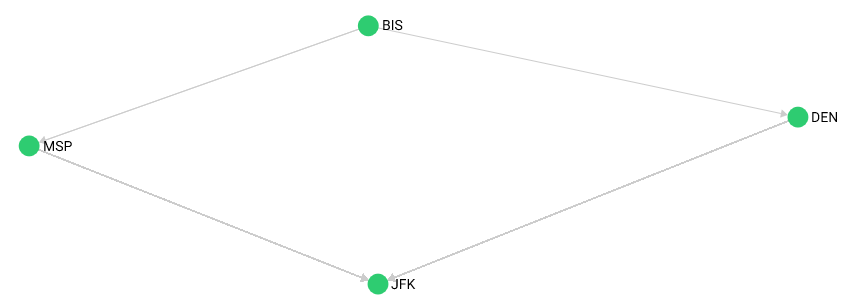

# Summary

ArangoDB AQL | Neo4j Cypher
:- | :-
`For ... IN ... RETURN` | `MATCH ... RETURN`
`FILTER` | `WHERE`
`SORT` | `ORDER BY`
`LIMIT` | `LIMIT`
`OUTBOUND` | `-->`
`INBOUND` | `<--`
`ANY` | `--`
`INSERT ... INTO` | `CREATE`
`UPDATE ... IN` | `SET`
`REMOVE ... IN` | `DELETE`

# Further Links

* [Download ArangoDB](https://arangodb.com/download/)

*Note that this notebook uses a temporary instance which will be autodeleted!*

* [AQL Documentation](https://docs.arangodb.com/stable/aql/)
* [Comparing ArangoDB AQL to Neo4j Cypher](https://arangodb.com/learn/graphs/comparing-arangodb-aql-neo4j-cypher/)